# Space junk simulation

In [1]:
import os
import matplotlib.pyplot as plt
import subprocess
import json
import math
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

Основной используемый объект - бинарник gpu_spacejunk.exe. Программа принимает на вход единственный аргумент - путь к конфигурационному файлу, который содержит описание модели и пути для выходных данных. Подробное описание конфигурационного файла есть на github.

Напишем функцию, которая принимает на вход все необходимую информацию о модели и возвращает требуемые траектории и опасные сближения, запуская нужный бинарник.

### TL;DR
Запускаем $run\_simulations$:

$time$ - время начала моделирования, с

$dt$ - интервал, через который считается новая позиция, с

$steps$ - кол-во итераций

$maxSteps$ - максимальное кол-во шагов, которое будет за 1 раз промоделировано на GPU

$objects$ - массив объектов. Объект - массив из 7 чисел: x, y, z, vx, vy, vz, size - начальное положение, скорость и размер

$forces$ - массив строк-идентификаторов сил (см. добавление сил на github)

$log\_trajectories$ - массив из индексов объектов, для которых надо запомнить траекторию

$collision\_options$ - опция для поиска сближений. Если "disabled" - не ищем коллизии, если "slow" - то ищем за квадрат, иначе - ищем быстрым алгоритмом

Возвращает пару:

$trajectories$ - словарь {индекс объекта : массив из его траекторий}

$collisions$ - массив троек: (время, id объекта, id объекта)



Запускаем $draw\_trajectories$ - передаем $trajectories$ из $run\_simulations$. Получаем картинку.

In [2]:
!cd ../ &&\
nvcc src/gpu_main.cu src/gpu/gpu_solver.cu src/model.cu -o bin/gpu_spacejunk.exe 


src/gpu/gpu_solver.cu(25): warning: variable "M" was declared but never referenced

src/gpu/gpu_solver.cu(26): warning: variable "G" was declared but never referenced

src/gpu/gpu_solver.cu(110): warning: variable "dt1" was declared but never referenced

src/gpu/gpu_solver.cu(111): warning: variable "dh" was declared but never referenced



In [3]:
def run_simulation(time, dt, steps, max_steps, objects, forces, log_trajectories, collision_option=""):
    with open("./cfg.txt", "w") as f:
        f.write(' '.join([str(x) for x in [time, dt, max_steps, steps]]) + '\n')
        f.write(str(len(objects)) + '\n')
        for obj in objects:
            f.write(' '.join([str(x) for x in obj]) + '\n')
        f.write(str(len(log_trajectories)) + '\n')
        f.write(' '.join([str(x) for x in log_trajectories]) + '\n')
        f.write(str(len(forces)) + '\n')
        f.write(' '.join(forces) + '\n')
        f.write("trajectories.txt\n")
        f.write("collisions.txt\n")
        f.write("\n")
        
    FNULL = open(os.devnull, 'w')
    args = ["../bin/gpu_spacejunk.exe",  "./cfg.txt"]
    res = subprocess.call(args, stdout=FNULL, stderr=FNULL, shell=False)
    if res:
        return None
    
    trajectories = {}
    with open("trajectories.txt") as tr:
        if tr:
            line = tr.readline()
            cur_id = None
            while (line):
                coords = line.split()
                if len(coords) == 1:
                    cur_id = int(coords[0])
                    trajectories[cur_id] = []
                else:
                    trajectories[cur_id].append([float(x) for x in coords])
                line = tr.readline()
    
    collisions = []
    with open("collisions.txt") as coll:
        if coll:
            line = coll.readline()
            while (line):
                collision = line.split()
                collisions.append((float(collisions[0]), int(collision[1]), int(collisions[2])))
                line = coll.readline()
    return trajectories, collisions

Попробуем запустить функцию на простейшем примере - единственный объект вращается по окружности в проскости $z=0$ на расстоянии $1.2R$ от центра Земли.

In [4]:
M = 5.972e24
R = 6.371e6
G = 6.67408e-11

res = run_simulation(0.0, 1.0, 10000, 100, [[0.0, 1.2 * R, 0.0, (G * M / (1.2 * R)) ** 0.5, 0.0, 0.0, 1.0]], ['gravity'], [0])
print(len(res[0][0]))
for coords in res[0][0][:10]:
    print(coords)

10000
[7220.397604382382, 7645196.59039965, 0.0, 7220.395457617271, -6.819200193012766, 0.0]
[14440.788768470149, 7645186.361601641, 0.0, 7220.385797176783, -13.638394303582336, 0.0]
[21661.16705197443, 7645169.313615098, 0.0, 7220.3696964522105, -20.457576249270936, 0.0]
[28881.526014617837, 7645145.446455225, 0.0, 7220.3471554579155, -27.27673994765165, 0.0]
[36101.85921614023, 7645114.760143313, 0.0, 7220.318174214003, -34.09587931631383, 0.0]
[43322.16021630443, 7645077.25470673, 0.0, 7220.282752746323, -40.91498827286853, 0.0]
[50542.42257490199, 7645032.930178932, 0.0, 7220.24089108647, -47.73406073495393, 0.0]
[57762.639851758926, 7644981.786599453, 0.0, 7220.192589271783, -54.553090620240766, 0.0]
[64982.80560674147, 7644923.824013911, 0.0, 7220.137847345344, -61.372071846437755, 0.0]
[72202.9133997618, 7644859.042474007, 0.0, 7220.076665355983, -68.190998331297, 0.0]


In [5]:
def draw_trajectories(trajectories):
    fig = pyplot.figure()
    ax = Axes3D(fig)
    for index, points in trajectories.items():
        x_coord = [i[0] for i in points]
        y_coord = [i[1] for i in points]
        z_coord = [i[2] for i in points]
        ax.scatter(x_coord, y_coord, z_coord)
    pyplot.show()

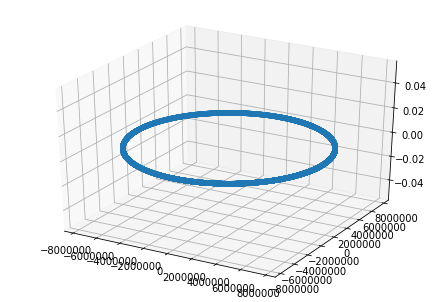

In [6]:
draw_trajectories(res[0])

# Тестирование

### Проверка корректности моделирования

Проверим, что в самом простом случае (вращение по окружности в плоскости $z=0$) выполненяются 2 инварианта: расстояние до центра постоянно и скорость постоянна.

In [7]:
M = 5.972e24
R = 6.371e6
G = 6.67408e-11

eps = 10 ** -1 
res = run_simulation(0.0, 1, 10000, 100, [[0.0, 1.2 * R, 0.0, (G * M / (1.2 * R)) ** 0.5, 0.0, 0.0, 1.0]], ['gravity'], [0])
start = res[0][0][0]
V = start[3] ** 2 + start[4] ** 2 + start[5] ** 2
for i, coords in enumerate(res[0][0]):
    if abs((coords[0] ** 2 + coords[1] ** 2 + coords[2] ** 2) ** 0.5 - 1.2 * R) > eps:
        print("Test failed: R")
        print("Step " + str(i))
        print("Diff is " + str(abs((coords[0] ** 2 + coords[1] ** 2 + coords[2] ** 2) ** 0.5 - 1.2 * R)))
        break
    if abs((coords[3] ** 2 + coords[4] ** 2 + coords[5] ** 2) ** 0.5 - V ** 0.5) > eps:
        print("Test failed: V")
        print("Step " + str(i))
        print("Diff is " + str(abs((coords[3] ** 2 + coords[4] ** 2 + coords[5] ** 2) ** 0.5 - V ** 0.5)))
        break

Построим траектории нескольких объектов - ожидаем увидеть эллипсы.

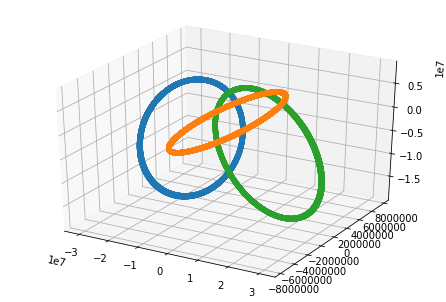

In [8]:
res = run_simulation(0.0, 100, 10000, 100, 
                     [
                         [0.0, 1.2 * R, 0.0, (G * M / (1.2 * R)) ** 0.5, 0.0, 0.0, 1.0],
                         [1.2 * R, 0.0, 1.2 * R, (G * M / (1.2 * R)) ** 0.5, 0.0, 0.0, 1.0],
                         [- 1.2 * R, 0.0, 1.2 * R, (G * M / (1.2 * R)) ** 0.5, 0.0, 0.0, 1.0]
                     ], 
                     ['gravity'],
                     [0, 1, 2])
draw_trajectories(res[0])

### Проверка корректности поиска сближений

### Оценка времени работы симуляции